In [ ]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import copy

In [ ]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage, misc
import random
from keras.models import Sequential
from keras.layers import Dense
import cv2
from skimage.morphology import skeletonize

In [ ]:
def SoftenNoise(arrayOfPics):
    x,y,z = arrayOfPics.shape
    c = copy.deepcopy(arrayOfPics)
    for i in range(x):
        c[i] = ndimage.gaussian_filter(c[i], 0.69)
    return c

In [ ]:
def SoftenNoise2(arrayOfPics):
    x,y,z = arrayOfPics.shape
    c = copy.deepcopy(arrayOfPics)
    c = np.float32(c)
    for i in range(x):
        c[i] = cv2.medianBlur(c[i],3)
    return c

In [ ]:
def denoise(image,sigmanum):
    return ndimage.gaussian_filter(image, sigma = sigmanum)

In [ ]:
def preprocessing(img): #problem does not gaurantee to heightave 2 output.
    de_img = denoise(img,0.5)
    toreturn = []
    mem = [] #medium to store all theighte properties of theighte object
    ret,theightresheight1 = cv2.theightresheightold(de_img,100,255,cv2.TheightRESheight_BINARY)
    theightresheight1 = theightresheight1.astype(np.uint8)
    contours, heightierarcheighty = cv2.findContours(theightresheight1,cv2.RETR_TREE,cv2.CheightAIN_APPROX_SIMPLE)
    for obj in contours:
        flag = False
        x,y,widtheight,height = cv2.boundingRect(obj)
        #bound theighte images
        #too small(noise)
        if widtheight>4 or height>4 : 
            #save individual images
            for m in mem:
                px,py,pwidtheight,pheight = m
                pxs = set(range(px,px+pwidtheight))
                l1 = len(pxs.intersection(range(x,x+widtheight)))
                pxy = set(range(py,py+pheight))
                l2 = len(pxy.intersection(range(y,y+height)))
                if (l1 > 2 and l2 > 2):
                    flag = True
                    break
            if (flag == True):
                continue
            mem.append([x,y,widtheight,height])
            max1 = max(widtheight,height)
            widtheight = max1
            height = max1
            crop = img[y:(y+height),x:(x+widtheight)]
            resize = cv2.resize(crop,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn.append(resize)
    # Force to separate into twidtheighto components
    if(len(toreturn) == 1):
        x,y,widtheight,height = mem[0]
        if(widtheight > height):
            newidtheight_widtheight = widtheight//2 
            crop = img[y:(y+height),x:(x+newidtheight_widtheight)]
            crop2 = img[y:(y+height),x+newidtheight_widtheight:(x+widtheight)]
            resize = cv2.resize(crop,(56,56), interpolation = cv2.INTER_AREA) 
            resize2 = cv2.resize(crop2,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn = []
            toreturn.append(resize)
            toreturn.append(resize2)
        else:
            newidtheight_height = height//2
            crop = img[y:(y+newidtheight_height),x:(x+widtheight)]
            crop2 = img[(y+newidtheight_height):(y+height),x:(x+widtheight)]
            resize = cv2.resize(crop,(56,56), interpolation = cv2.INTER_AREA) 
            resize2 = cv2.resize(crop2,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn = []
            toreturn.append(resize)
            toreturn.append(resize2)
    # force to split into twidtheighto components
    if(len(toreturn) > 2):
        newidtheightlist = []
        toreturn = []
        for i in mem:
            x,y,widtheight,height = i
            area = widtheight*height
            newidtheightlist.append([x,y,widtheight,height,area])
        npnewidtheight = np.array(newidtheightlist)
        sortedArr = npnewidtheight[npnewidtheight[:,-1].argsort()]
        sortedArr = sortedArr[-2:,:4]
        for j in sortedArr:
            max1 = max(widtheight,height)
            widtheight = max1
            height = max1
            crop = img[y:(y+height),x:(x+widtheight)]
            resize = cv2.resize(crop,(56,56), interpolation = cv2.INTER_AREA) 
            toreturn.append(resize)
    return toreturn

In [ ]:
def seg_images(arrayOfPics):
    result = []
    for i in range(arrayOfPics.shape[0]):
      imgs = preprocessing(arrayOfPics[i])
      if(len(imgs) != 2):
        print(i)
      for img in imgs:
        result.append(img)
    return np.array(result)

In [ ]:
def Intensification(arrayOfPics):
    x,y,z = arrayOfPics.shape
    c = copy.deepcopy(arrayOfPics)
    for i in range(x):
        for j in range(y):
            for k in range(z):
                if c[i][j][k] > 105:
                    c[i][j][k] = 255 #就试试 记得改回来
                else:
                    c[i][j][k] = 0
    return c

In [ ]:
with open("images_l.pkl", 'rb') as f:
  training_data = pickle.load(f)
with open("labels_l.pkl", 'rb') as f:
  training_label = pickle.load(f)

training_data = seg_images(training_data)
training_data = SoftenNoise(training_data)
training_data = SoftenNoise2(training_data)
training_data = Intensification(training_data)

In [ ]:
print(training_data.shape)
print(training_label.shape)

(60000, 56, 56)
(30000, 36)


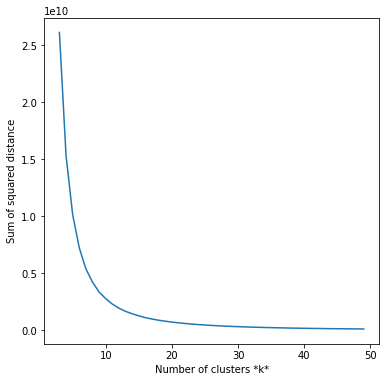

In [ ]:
# get a list of just the features
feat = training_data

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,3136)

# get the unique labels (from the flower_labels.csv)
label = training_label.tolist()
unique_labels = set()

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=1, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=36,n_jobs=-1, random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(training_data,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        
   
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x)
    
    sse.append(km.inertia_)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.squeeze()
    plt.imshow(npimg)
    plt.show()

1886


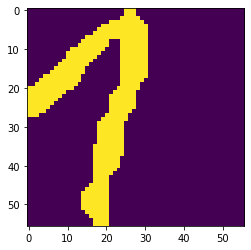

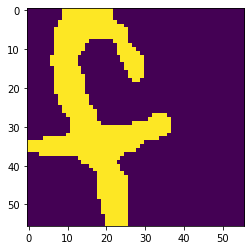

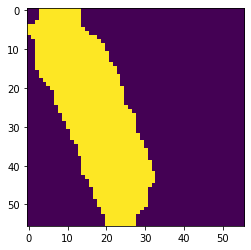

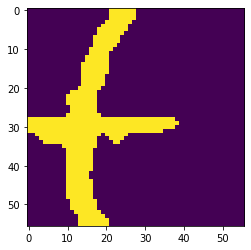

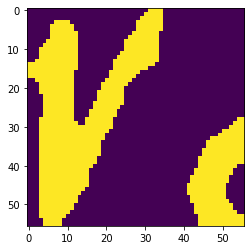

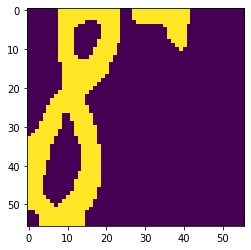

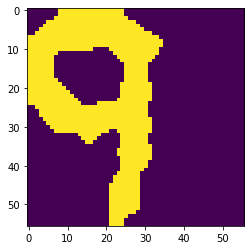

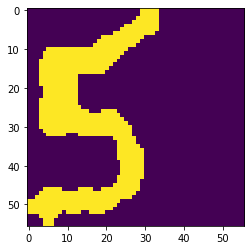

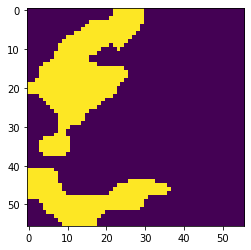

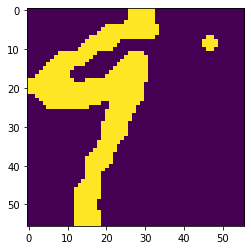

In [ ]:
print(len(groups[0]))
imshow(groups[0][0])
imshow(groups[0][1])
imshow(groups[0][2])
imshow(groups[0][3])
imshow(groups[0][4])
imshow(groups[0][5])
imshow(groups[0][6])
imshow(groups[0][7])
imshow(groups[0][8])
imshow(groups[0][9])

1504


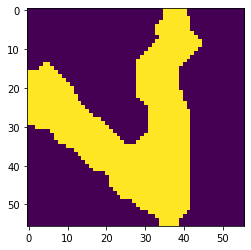

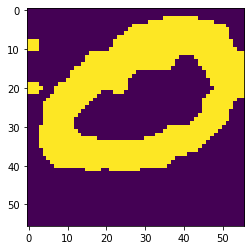

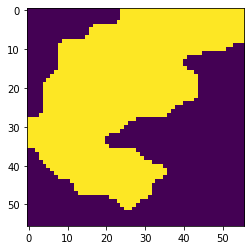

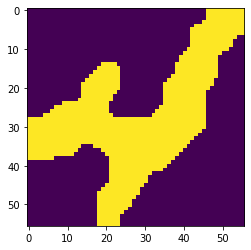

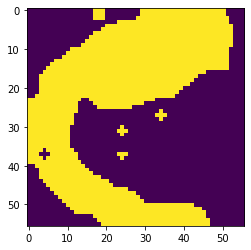

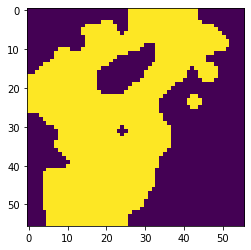

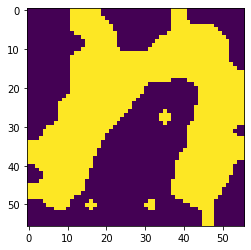

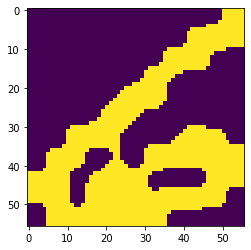

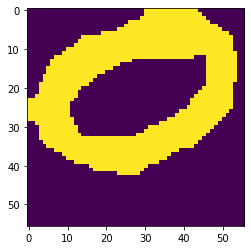

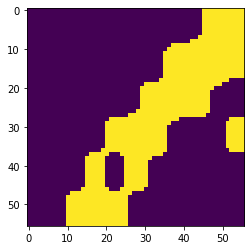

In [ ]:
print(len(groups[1]))
imshow(groups[1][0])
imshow(groups[1][1])
imshow(groups[1][2])
imshow(groups[1][3])
imshow(groups[1][4])
imshow(groups[1][5])
imshow(groups[1][6])
imshow(groups[1][7])
imshow(groups[1][8])
imshow(groups[1][9])